# Détermination du portrait de phase à partir de la diffusion des particules

#### L'idée derrière cette approche est la suivante : on s'intéresse à une transition liquide-solide du fluide de Lennard-Jones. En phase solide, les atomes bougent très peu autour de leur position d'équilibre alors qu'en phase fluide, ils bougent bien plus. On souhaite repérer la transition de phase en observant une rupture nette dans la valeur des MSD.

## Importation des librairies et des routines

In [1]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)
from library import *

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

### Une première trajectoire

In [2]:
# define system
d=2
NParticles=16
kT = 0.34
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# choose density
rho = 0.5/sigma**d
print('Densité=', rho, 'sigma**',d)
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 50. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

tau= 1.0
Densité= 0.5 sigma** 2
LBox =  5.656854249492381
Execution time:  4.425231214991072


Animation de la trajectoire générée:

1


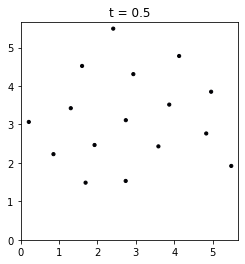

In [38]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but onfigurations were stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
#skip=int( (t_tr.size-1)/(x_tr.shape[0]-1) )
skip=1
print(skip)

MD.AnimateMDRun(t_tr[::skip],x_tr,y_tr,xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

Plot des trajectoires des différentes particules

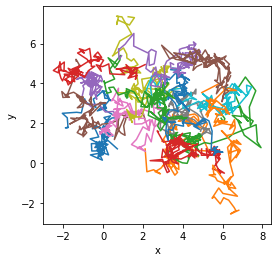

In [3]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

ainsi que leur MSD

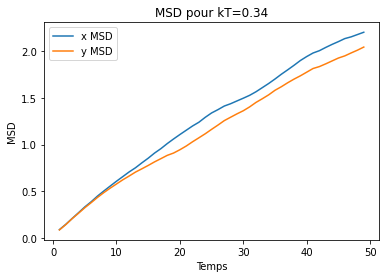

In [4]:
delta_t, x_msd = MeanSquareDisplacements(t_tr,x_tr)
delta_t, y_msd = MeanSquareDisplacements(t_tr,y_tr)
plt.plot(delta_t,x_msd,label='x MSD')
plt.plot(delta_t,y_msd,label='y MSD')
plt.title('MSD pour kT={}'.format(kT))
plt.ylabel('MSD')
plt.xlabel('Temps')
plt.legend()

## Génération d'un ensemble de trajectoires à $kT$ et $\rho$ fixés

#### Pour élminier le plus possible les effets statistiques, on s'intéresse à un ensemble de trajectoires à $kT$ et $\rho$ fixés. Ainsi, par la suite, on ne s'intéressera qu'à des données obtenues en moyennant sur un certain nombre de trajectoires.

In [3]:
# define system
NParticles=16
d=2
kT = .5
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**d
LBox = np.power(NParticles/rho,1/2)
print('kT=',kT)
print('rho=',rho)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 50. * tau

# define number of independent trajectories
NTrajectories = 5
print('Nombre de trajectoires:', NTrajectories)

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

(t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
 uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
 list_of_starting_configurations) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

kT= 0.5
rho= 0.5
LBox =  5.656854249492381
Nombre de trajectoires: 5
Execution time:  29.43350568599999


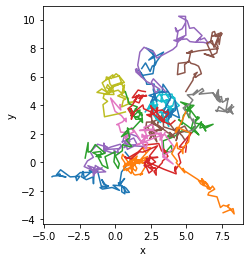

In [4]:
#Tracé de la trajectoire des particules pour 1 simulation
ax = plt.axes()
Traj=1
MD.AddParticleTraces(ax,x_tr_ens[Traj],y_tr_ens[Traj],range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

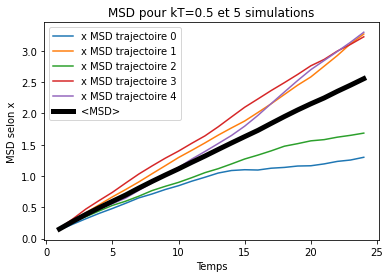

In [5]:
x_msd_ens=[]

for i in range(len(x_tr_ens)):
    delta_t, x_msd = MeanSquareDisplacements(t_tr_ens[i],x_tr_ens[i])
    plt.plot(delta_t,x_msd,label='x MSD trajectoire {}'.format(i))
    x_msd_ens.append(x_msd)

x_msd_ens=np.array(x_msd_ens)

x_msd_ens_mean=np.mean(x_msd_ens.transpose(),axis=-1)

plt.plot(delta_t,x_msd_ens_mean,linewidth=5,label='<MSD>',color='black')
plt.title('MSD pour kT={} et {} simulations'.format(kT,NTrajectories))
plt.xlabel('Temps')
plt.ylabel('MSD selon x')
plt.legend()

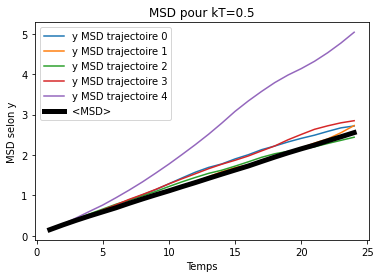

In [6]:
y_msd_ens=[]

for i in range(len(y_tr_ens)):
    delta_t, y_msd = MeanSquareDisplacements(t_tr_ens[i],y_tr_ens[i])
    plt.plot(delta_t,y_msd,label='y MSD trajectoire {}'.format(i))
    y_msd_ens.append(y_msd)

y_msd_ens=np.array(y_msd_ens)

y_msd_ens_mean=np.mean(x_msd_ens.transpose(),axis=-1)

plt.plot(delta_t,y_msd_ens_mean,linewidth=5,color='black',label='<MSD>')
    
plt.title('MSD pour kT={}'.format(kT))
plt.xlabel('Temps')
plt.ylabel('MSD selon y')
plt.legend()

## Balayage en température à $\rho$ fixé.

#### On regarde maintenant un balayage en température à $\rho$ fixé et on essaye d'observer une transition de phase en observant une rupture dans la valeur du MSD à l'équilibre.

In [3]:
rho_range=np.array([0.1])/(sigma**d)
kT_range = np.linspace(0.3,1,20)
print(rho_range)
print(kT_range)

[0.1]
[0.3        0.33684211 0.37368421 0.41052632 0.44736842 0.48421053
 0.52105263 0.55789474 0.59473684 0.63157895 0.66842105 0.70526316
 0.74210526 0.77894737 0.81578947 0.85263158 0.88947368 0.92631579
 0.96315789 1.        ]


In [4]:
#### When in doubt use a small number of particles to speed up the simulations
# In a perfect world (as opposed to an exam), we would generate data for different systems sizes 
# and study finite size effects.

NParticles = 16
m = np.ones(NParticles)
d = 2

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# Not much fun, if we reduce this even further
NTrajectories = 10
run_time_equilibration = 2
run_time_data_acquisition = 20

print("One sweep over all state points corresponds to ", rho_range.size * kT_range.size * NTrajectories," separate simulations!")

# On my computer each of the for "sweeps" below took 2 minutes. If you are worried about time try first with
# NTrajectories = 1

tau= 1.0
One sweep over all state points corresponds to  200  separate simulations!


In [5]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_heating = {}
x_tr_ens_from_NVT_heating = {}
y_tr_ens_from_NVT_heating = {}
vx_tr_ens_from_NVT_heating = {}
vy_tr_ens_from_NVT_heating = {}
uPot_tr_ens_from_NVT_heating = {}
uKin_tr_ens_from_NVT_heating = {}
pPot_tr_ens_from_NVT_heating = {}
pKin_tr_ens_from_NVT_heating = {}
list_of_starting_configurations_from_NVT_heating = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in kT_range:
        i=0
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # using floats as key can lead to difficulties, because of their inexact representation
        print('key=',key)
                # Generate data
        run_time = 50. *tau
        (t_tr_ens_from_NVT_heating[key], 
         x_tr_ens_from_NVT_heating[key], 
         y_tr_ens_from_NVT_heating[key], 
         vx_tr_ens_from_NVT_heating[key], 
         vy_tr_ens_from_NVT_heating[key],
         uPot_tr_ens_from_NVT_heating[key], 
         uKin_tr_ens_from_NVT_heating[key], 
         pPot_tr_ens_from_NVT_heating[key], 
         pKin_tr_ens_from_NVT_heating[key],
         list_of_starting_configurations_from_NVT_heating[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.1 , kT =  0.3
key= (16, '0.1', '0.3')
rho =  0.1 , kT =  0.3368421052631579
key= (16, '0.1', '0.34')
rho =  0.1 , kT =  0.3736842105263158
key= (16, '0.1', '0.37')
rho =  0.1 , kT =  0.41052631578947363
key= (16, '0.1', '0.41')
rho =  0.1 , kT =  0.4473684210526315
key= (16, '0.1', '0.45')
rho =  0.1 , kT =  0.4842105263157894
key= (16, '0.1', '0.48')
rho =  0.1 , kT =  0.5210526315789473
key= (16, '0.1', '0.52')
rho =  0.1 , kT =  0.5578947368421052
key= (16, '0.1', '0.56')
rho =  0.1 , kT =  0.5947368421052631
key= (16, '0.1', '0.59')
rho =  0.1 , kT =  0.631578947368421
key= (16, '0.1', '0.63')
rho =  0.1 , kT =  0.6684210526315789
key= (16, '0.1', '0.67')
rho =  0.1 , kT =  0.7052631578947368
key= (16, '0.1', '0.71')
rho =  0.1 , kT =  0.7421052631578946
key= (16, '0.1', '0.74')
rho =  0.1 , kT =  0.7789473684210526
key= (16, '0.1', '0.78')
rho =  0.1 , kT =  0.8157894736842104
key= (16, '0.1', '0.82')
rho =  0.1 , kT =  0.8526315789473684
key= (16, '0.1', '0.85')
rho =  0

Pour chaque température on fait un certain nombre de trajectoires, la cellule suivante calcule le MSD en faisant la moyenne sur toutes les trajectoires pour une température.

In [6]:
x_msd_mean_from_NVT_heating=[]
y_msd_mean_from_NVT_heating=[]

for i in range(len(kT_range)):
    key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
    x_msd_ens_from_NVT_heating=[]
    y_msd_ens_from_NVT_heating=[]
    
    for j in range(len(t_tr_ens_from_NVT_heating[key])):
        
        delta_t, x_msd = MeanSquareDisplacements(t_tr_ens_from_NVT_heating[key][j],x_tr_ens_from_NVT_heating[key][j])
        delta_t, y_msd = MeanSquareDisplacements(t_tr_ens_from_NVT_heating[key][j],y_tr_ens_from_NVT_heating[key][j])
        x_msd_ens_from_NVT_heating.append(x_msd)
        y_msd_ens_from_NVT_heating.append(y_msd)
        
    x_msd_ens_from_NVT_heating=np.array(x_msd_ens_from_NVT_heating)
    y_msd_ens_from_NVT_heating=np.array(y_msd_ens_from_NVT_heating)
    x_msd_mean_from_NVT_heating.append(np.mean(x_msd_ens_from_NVT_heating.transpose(),axis=-1))
    y_msd_mean_from_NVT_heating.append(np.mean(y_msd_ens_from_NVT_heating.transpose(),axis=-1))

On plot ensuite le MSD moyen calculé précédemment pour chaque température balayée.

Text(0.5, 0, 'Temps')

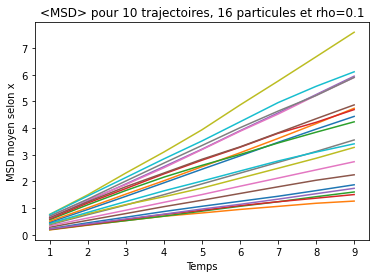

In [7]:
for i in range(len(x_msd_mean_from_NVT_heating)):
    plt.plot(delta_t,x_msd_mean_from_NVT_heating[i],label='kT={}'.format(round(kT_range[i],2)))

plt.title('<MSD> pour {} trajectoires, {} particules et rho={}'.format(NTrajectories,NParticles,rho_range[0]))
plt.ylabel('MSD moyen selon x')
plt.xlabel('Temps')
#plt.legend()

Text(0.5, 0, 'Temps')

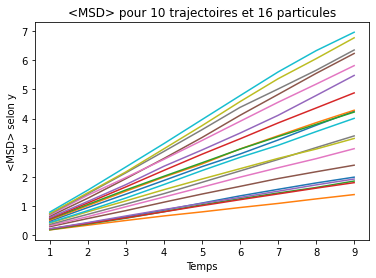

In [8]:
for i in range(len(y_msd_mean_from_NVT_heating)):
    plt.plot(delta_t,y_msd_mean_from_NVT_heating[i],label='kT={}'.format(round(kT_range[i],2)))

plt.title('<MSD> pour {} trajectoires et {} particules'.format(NTrajectories,NParticles))
plt.ylabel('<MSD> selon y')
plt.xlabel('Temps')
#plt.legend()

On observe effectivement une rupture dans les valeurs du MSD. Celle-ci devrait être plus marquée en augmentant le nombre de particules ainsi que le nombre de trajectoires faite pour une température. Il faut maintenant trouver un critère quantitatif pour repérer la transition de phase. 

### Critère pour déterminer la transition de phase

On chercher maintenant à déterminer où a lieu la transition de phase. On va donc regarder les écarts entre les coeffs de diffusion au dernier temps t, et on dit qu'il y a transition de phase lorsqu'il y a un premier gros saut. Comment quantifier ce premier gros saut ?
Ma première idée est la suivante : on crée une liste contenant toutes les dernières valeurs des coefficients de diffusion pour chaque $kT$. On regarde ensuite les écarts deux à deux et on contrôle le plus grand écart.

#### Implémentation dans la direction $x$

Pour plus de commodité, on trie la liste contenant les derniers coefficients MSD de chaque température par ordre croissant.

In [9]:
last_coeff_x=[]
last_coeff_sorted_x=[]
for i in range(len(kT_range)):
    key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
    last_coeff_x.append([kT_range[i],(x_msd_mean_from_NVT_heating[i])[-1]])
    last_coeff_sorted_x.append(last_coeff_x[i][1])
    
last_coeff_x=np.array(last_coeff_x)
last_coeff_sorted_x=np.sort(last_coeff_sorted_x)

last_coeff_ordered_x=[]
for elem in last_coeff_sorted_x:
    for elem_bis in last_coeff_x:
        if elem==elem_bis[1]:
            last_coeff_ordered_x.append((elem_bis[0],elem_bis[1]))
last_coeff_ordered_x=np.array(last_coeff_ordered_x)

In [10]:
print(last_coeff_ordered_x)
len(last_coeff_ordered_x)

[[0.33684211 1.25979628]
 [0.41052632 1.50410917]
 [0.37368421 1.60124124]
 [0.44736842 1.73806737]
 [0.3        1.87125119]
 [0.48421053 2.24616682]
 [0.52105263 2.73594094]
 [0.59473684 3.27274715]
 [0.63157895 3.40690597]
 [0.55789474 3.55257871]
 [0.74210526 4.23197894]
 [0.66842105 4.43512366]
 [0.77894737 4.69072139]
 [0.70526316 4.74042172]
 [0.85263158 4.86679586]
 [0.88947368 5.89676573]
 [0.92631579 5.89810353]
 [0.81578947 5.94444565]
 [1.         6.10828846]
 [0.96315789 7.59165543]]


20

On plot maintenant la valeur de ce dernier coefficient avant de voir ce qu'il se passe.

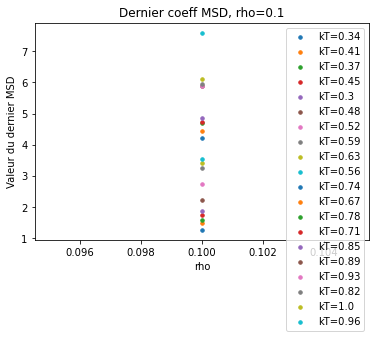

In [11]:
for elem in last_coeff_ordered_x:
    plt.scatter(rho,elem[1],label='kT={}'.format(round(elem[0],2)),s=12)
    
plt.title('Dernier coeff MSD, rho={}'.format(rho_range[0]))
plt.xlabel('rho')
plt.ylabel('Valeur du dernier MSD')
plt.legend()

Pour observer le premier gros saut, une méthode qui a l'air de plutôt bien marcher (empirique) est de regarder qu'une partie des points. C'est ce qu'on fait dans la suite

In [12]:
maximum_x=0
i_transition_x=0
print(len(kT_range)//2)
for i in range(len(kT_range)//2-3):
    diff_x=(last_coeff_ordered_x[i+1][1]-last_coeff_ordered_x[i][1])
    if diff_x>1.1*maximum_x:
        maximum_x=diff_x
        i_transition_x=i
    print(diff_x)
    print(i_transition_x)


10
0.24431289455409355
0
0.09713206526198315
0
0.13682613424448453
0
0.1331838216506842
0
0.3749156296398044
4
0.48977411593864995
5
0.536806215498959
5


Mon raisonnement est le suivant: ici, pour pouvoir déterminer au mieux où avait lieu la transition de phase, j'ai ordonné dans l'ordre croissant les coeff MSD, puisque en dessous du kT de transition, les comportements étant solides, les MSD sont tous très proches. On obtient ainsi une valeur de transition mais ce n'est pas la valeur physique, il faut prendre la valeur max pour tous les points qui sont en dessous de cette valeur.

In [13]:
kT_transition_x=last_coeff_ordered_x[0][0]
for i in range(i_transition_x+1):
    if last_coeff_ordered_x[i][0]>=kT_transition_x:
        kT_transition_x=last_coeff_ordered_x[i][0]
        
print('La différence maximum est {}, donc la transition de phase semble être pour kT={}'.format(
    maximum_x,round(kT_transition_x,2)))

La différence maximum est 0.48977411593864995, donc la transition de phase semble être pour kT=0.48


#### Implémentation dans la direction $y$

In [14]:
last_coeff_y=[]
last_coeff_sorted_y=[]
for i in range(len(kT_range)):
    key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
    last_coeff_y.append([kT_range[i],(y_msd_mean_from_NVT_heating[i])[-1]])
    last_coeff_sorted_y.append(last_coeff_y[i][1])
    
last_coeff_y=np.array(last_coeff_y)
last_coeff_sorted_y=np.sort(last_coeff_sorted_y)

last_coeff_ordered_y=[]
for elem in last_coeff_sorted_y:
    for elem_bis in last_coeff_y:
        if elem==elem_bis[1]:
            last_coeff_ordered_y.append((elem_bis[0],elem_bis[1]))
last_coeff_ordered_y=np.array(last_coeff_ordered_y)

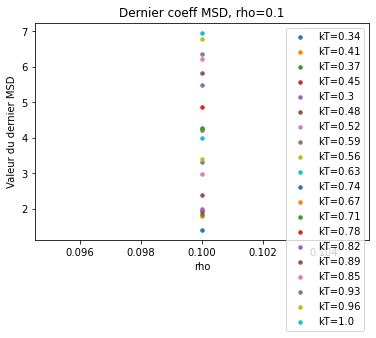

In [15]:
for elem in last_coeff_ordered_y:
    plt.scatter(rho,elem[1],label='kT={}'.format(round(elem[0],2)),s=12)
    
plt.title('Dernier coeff MSD, rho={}'.format(rho_range[0]))
plt.xlabel('rho')
plt.ylabel('Valeur du dernier MSD')
plt.legend()

In [16]:
maximum_y=0
i_transition_y=0

for i in range(len(kT_range)//2-3):
    diff_y=(last_coeff_ordered_y[i+1][1]-last_coeff_ordered_y[i][1])
    if diff_y>maximum_y:
        maximum_y=diff_y
        i_transition_y=i
    print(diff_y)
    print(i_transition_y)

kT_transition_y=last_coeff_ordered_y[0][0]
for i in range(i_transition_y+1):
    if last_coeff_ordered_y[i][0]>kT_transition_y:
        kT_transition_y=last_coeff_ordered_y[i][0]
        
print('La différence maximum est {}, donc la transition de phase semble être pour kT={}'.format(
    maximum_y,round(kT_transition_y,2)))

0.4086982984557228
0
0.05485224175650205
0
0.06938412983548714
0
0.06422026978168982
0
0.40994842860829905
4
0.5658458984161006
5
0.3504284912423361
5
La différence maximum est 0.5658458984161006, donc la transition de phase semble être pour kT=0.48


#### Calcul du kT de transition final

Une fois le $kT$ de transition obtenu pour un $\rho$ dans les directions $x$ et $y$, on fait la moyenne de ces deux valeurs pour obtenir la valeur a la transition (cet argument fonctionne car le système est isotrope).

In [17]:
# Par isotropie : 

kT_transition_final=(kT_transition_x+kT_transition_y)/2
print(kT_transition_final)

0.4842105263157894


# Implémentation pour différents $\rho$

Il suffit de réutiliser tout ce qu'on a fait jusqu'à présent, les insérer dans une boucle et de balayer les $\rho$

In [32]:
rho_range=np.array(np.linspace(0.05,0.8,10))
kT_range = np.array(np.linspace(0.3,1,20))
print('rho=',rho_range)
print('kT=',kT_range)

rho= [0.05       0.13333333 0.21666667 0.3        0.38333333 0.46666667
 0.55       0.63333333 0.71666667 0.8       ]
kT= [0.3        0.33684211 0.37368421 0.41052632 0.44736842 0.48421053
 0.52105263 0.55789474 0.59473684 0.63157895 0.66842105 0.70526316
 0.74210526 0.77894737 0.81578947 0.85263158 0.88947368 0.92631579
 0.96315789 1.        ]


In [33]:
#### When in doubt use a small number of particles to speed up the simulations
# In a perfect world (as opposed to an exam), we would generate data for different systems sizes 
# and study finite size effects.

NParticles = 32
m = np.ones(NParticles)
d = 2

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# Not much fun, if we reduce this even further
NTrajectories = 15
run_time_equilibration = 2
run_time_data_acquisition = 20

print("One sweep over all state points corresponds to ", rho_range.size * kT_range.size * NTrajectories," separate simulations!")

# On my computer each of the for "sweeps" below took 2 minutes. If you are worried about time try first with
# NTrajectories = 1

tau= 1.0
One sweep over all state points corresponds to  3000  separate simulations!


rho =  0.05 , kT =  0.3
key= (32, '0.05', '0.3')
rho =  0.05 , kT =  0.3368421052631579
key= (32, '0.05', '0.34')
rho =  0.05 , kT =  0.3736842105263158
key= (32, '0.05', '0.37')
rho =  0.05 , kT =  0.41052631578947363
key= (32, '0.05', '0.41')
rho =  0.05 , kT =  0.4473684210526315
key= (32, '0.05', '0.45')
rho =  0.05 , kT =  0.4842105263157894
key= (32, '0.05', '0.48')
rho =  0.05 , kT =  0.5210526315789473
key= (32, '0.05', '0.52')
rho =  0.05 , kT =  0.5578947368421052
key= (32, '0.05', '0.56')
rho =  0.05 , kT =  0.5947368421052631
key= (32, '0.05', '0.59')
rho =  0.05 , kT =  0.631578947368421
key= (32, '0.05', '0.63')
rho =  0.05 , kT =  0.6684210526315789
key= (32, '0.05', '0.67')
rho =  0.05 , kT =  0.7052631578947368
key= (32, '0.05', '0.71')
rho =  0.05 , kT =  0.7421052631578946
key= (32, '0.05', '0.74')
rho =  0.05 , kT =  0.7789473684210526
key= (32, '0.05', '0.78')
rho =  0.05 , kT =  0.8157894736842104
key= (32, '0.05', '0.82')
rho =  0.05 , kT =  0.8526315789473684
ke

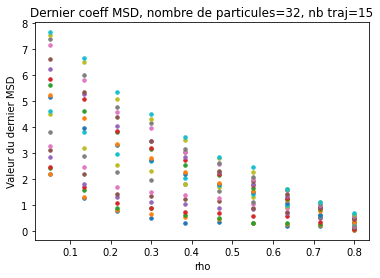

In [34]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_heating = {}
x_tr_ens_from_NVT_heating = {}
y_tr_ens_from_NVT_heating = {}
vx_tr_ens_from_NVT_heating = {}
vy_tr_ens_from_NVT_heating = {}
uPot_tr_ens_from_NVT_heating = {}
uKin_tr_ens_from_NVT_heating = {}
pPot_tr_ens_from_NVT_heating = {}
pKin_tr_ens_from_NVT_heating = {}
list_of_starting_configurations_from_NVT_heating = {}

liste_max=[]
liste_MSD_transition=[]
liste_kT_transition_x=[]
liste_kT_transition_y=[]

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in kT_range:
        i=0
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # using floats as key can lead to difficulties, because of their inexact representation
        print('key=',key)
                # Generate data
        run_time = 50. *tau
        (t_tr_ens_from_NVT_heating[key], 
         x_tr_ens_from_NVT_heating[key], 
         y_tr_ens_from_NVT_heating[key], 
         vx_tr_ens_from_NVT_heating[key], 
         vy_tr_ens_from_NVT_heating[key],
         uPot_tr_ens_from_NVT_heating[key], 
         uKin_tr_ens_from_NVT_heating[key], 
         pPot_tr_ens_from_NVT_heating[key], 
         pKin_tr_ens_from_NVT_heating[key],
         list_of_starting_configurations_from_NVT_heating[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)
    
    x_msd_mean_from_NVT_heating=[]
    y_msd_mean_from_NVT_heating=[]

    for i in range(len(kT_range)):
        key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
        x_msd_ens_from_NVT_heating=[]
        y_msd_ens_from_NVT_heating=[]
    
    
        for j in range(len(t_tr_ens_from_NVT_heating[key])):
        
            delta_t, x_msd = MeanSquareDisplacements(t_tr_ens_from_NVT_heating[key][j],x_tr_ens_from_NVT_heating[key][j])
            delta_t, y_msd = MeanSquareDisplacements(t_tr_ens_from_NVT_heating[key][j],y_tr_ens_from_NVT_heating[key][j])
            x_msd_ens_from_NVT_heating.append(x_msd)
            y_msd_ens_from_NVT_heating.append(y_msd)
        
        x_msd_ens_from_NVT_heating=np.array(x_msd_ens_from_NVT_heating)
        y_msd_ens_from_NVT_heating=np.array(y_msd_ens_from_NVT_heating)
        x_msd_mean_from_NVT_heating.append(np.mean(x_msd_ens_from_NVT_heating.transpose(),axis=-1))
        y_msd_mean_from_NVT_heating.append(np.mean(y_msd_ens_from_NVT_heating.transpose(),axis=-1))
    
    last_coeff_x=[]
    last_coeff_sorted_x=[]
    for i in range(len(kT_range)):
        key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
        last_coeff_x.append([kT_range[i],(x_msd_mean_from_NVT_heating[i])[-1]])
        last_coeff_sorted_x.append(last_coeff_x[i][1])
    
    last_coeff_x=np.array(last_coeff_x)
    last_coeff_sorted_x=np.sort(last_coeff_sorted_x)

    last_coeff_ordered_x=[]
    for elem in last_coeff_sorted_x:
        for elem_bis in last_coeff_x:
            if elem==elem_bis[1]:
                last_coeff_ordered_x.append((elem_bis[0],elem_bis[1]))
    last_coeff_ordered_x=np.array(last_coeff_ordered_x)
    
    
    for elem in last_coeff_ordered_x:
        plt.scatter(rho,elem[1],label='kT={}'.format(round(elem[0],2)),s=12)

    maximum_x=0
    i_transition_x=0
    for i in range(len(kT_range)//2-3):
        diff_x=(last_coeff_ordered_x[i+1][1]-last_coeff_ordered_x[i][1])
        if diff_x>1.1*maximum_x:
            maximum_x=diff_x
            i_transition_x=i
            max_coeff_x=last_coeff_ordered_x[i][1]

    liste_max.append(maximum_x)
    liste_MSD_transition.append(max_coeff_x)
    

    kT_transition_x=last_coeff_ordered_x[0][0]
    for i in range(i_transition_x+1):
        if last_coeff_ordered_x[i][0]>=kT_transition_x:
            kT_transition_x=last_coeff_ordered_x[i][0]
    
    liste_kT_transition_x.append(kT_transition_x)
    
    
    
    last_coeff_y=[]
    last_coeff_sorted_y=[]
    for i in range(len(kT_range)):
        key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
        last_coeff_y.append([kT_range[i],(y_msd_mean_from_NVT_heating[i])[-1]])
        last_coeff_sorted_y.append(last_coeff_y[i][1])
    
    last_coeff_y=np.array(last_coeff_y)
    last_coeff_sorted_y=np.sort(last_coeff_sorted_y)

    last_coeff_ordered_y=[]
    for elem in last_coeff_sorted_y:
        for elem_bis in last_coeff_y:
            if elem==elem_bis[1]:
                last_coeff_ordered_y.append((elem_bis[0],elem_bis[1]))
    last_coeff_ordered_y=np.array(last_coeff_ordered_y)
    
    maximum_y=0
    i_transition_y=0

    for i in range(len(kT_range)//2-3):
        diff_y=(last_coeff_ordered_y[i+1][1]-last_coeff_ordered_y[i][1])
        if diff_y>maximum_y:
            maximum_y=diff_y
            i_transition_y=i

    kT_transition_y=last_coeff_ordered_y[0][0]
    for i in range(i_transition_y+1):
        if last_coeff_ordered_y[i][0]>kT_transition_y:
            kT_transition_y=last_coeff_ordered_y[i][0]
    
    liste_kT_transition_y.append(kT_transition_y)
    
plt.title('Dernier coeff MSD, nombre de particules={}, nb traj={}'.format(NParticles,NTrajectories))
plt.xlabel('rho')
plt.ylabel('Valeur du dernier MSD')
#plt.legend()
    
print("Execution time: ",time.perf_counter() - initialWallTime)

In [35]:
len(liste_kT_transition_x)

10

In [36]:
len(rho_range)

10

Text(0.5, 1.0, 'Diagramme de phase')

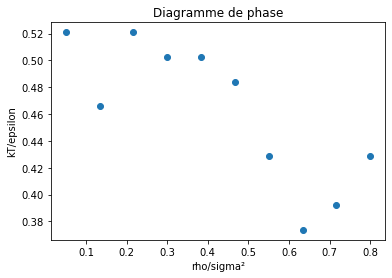

In [45]:
kT_transition_moyen=(np.array(liste_kT_transition_y)+np.array(liste_kT_transition_x))/2

plt.scatter(rho_range,kT_transition_moyen)
plt.ylabel('kT/epsilon')
plt.xlabel('rho/sigma²')
plt.title('Diagramme de phase')

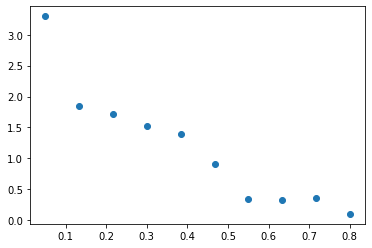

In [39]:
liste_max
plt.scatter(rho_range,liste_MSD_transition)